# Анализ данных и эксперименты

## Анализ температурных данных

Импорт библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Загрузка датасета:

In [2]:
DATA_PATH = 'data/temperature_data.csv'

In [3]:
data = pd.read_csv(DATA_PATH)

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

Вычисление скользящего среднего с окном в 30 дней для каждого города отдельно:

In [5]:
data['rolling_mean'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).mean())

Визуализация скользящего среднего:

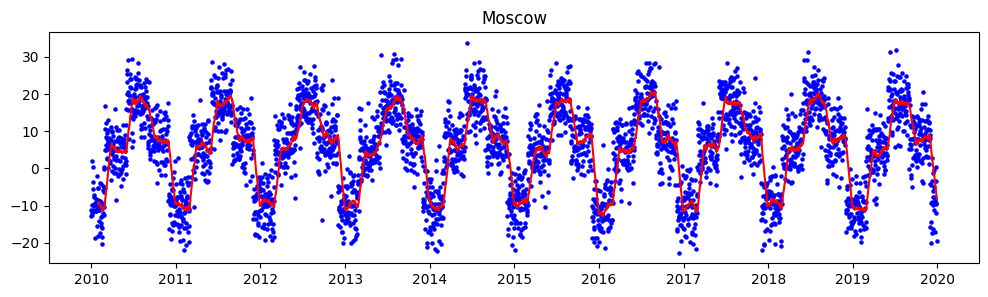

In [6]:
city = 'Moscow'
plt.figure(figsize=(12, 3))
plt.scatter(data[data['city'] == city]['timestamp'], data[data['city'] == city]['temperature'], s=5, c='blue')
plt.plot(data[data['city'] == city]['timestamp'], data[data['city'] == city]['rolling_mean'], c='red')
plt.title(city)
plt.show()

Вычисление скользящего стандартного отклонения с окном в 30 дней для каждого города отдельно:

In [7]:
data['rolling_std'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).std())

Выявление аномалий:

In [8]:
def is_anomaly(row: pd.Series) -> bool:
    """Проверка строки на аномальность."""

    return (row['temperature'] < row['rolling_mean'] - 2 * row['rolling_std']
            or row['temperature'] > row['rolling_mean'] + 2 * row['rolling_std'])

In [9]:
data['is_anomaly'] = data.apply(is_anomaly, axis=1)

Визуализация аномалий:

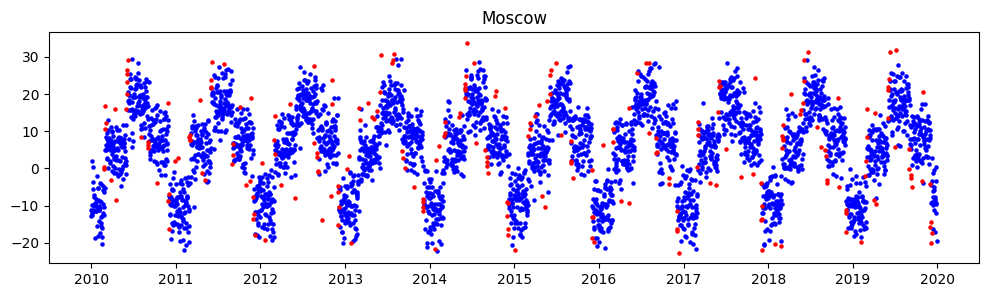

In [10]:
city = 'Moscow'
not_anomalies = data[(data['city'] == city) & (data['is_anomaly'] == False)]
anomalies = data[(data['city'] == city) & (data['is_anomaly'] == True)]
plt.figure(figsize=(12, 3))
plt.scatter(not_anomalies['timestamp'], not_anomalies['temperature'], s=5, c='blue')
plt.scatter(anomalies['timestamp'], anomalies['temperature'], s=5, c='red')
plt.title(city)
plt.show()

Вычисление статистик для каждого города и сезона:

In [11]:
stats = {}

for city in data['city'].unique():
    stats[city] = {}
    for season in data['season'].unique():
        stats[city][season] = {}
        stats[city][season]['mean'] = data[(data['city'] == city) & (data['season'] == season)]['temperature'].mean()
        stats[city][season]['std'] = data[(data['city'] == city) & (data['season'] == season)]['temperature'].std()

Пример вычисленных статистик:

In [12]:
pd.DataFrame(stats['Moscow'])

,winter,spring,summer,autumn
mean,-10.031616,5.387185,18.117777,7.933530
std,5.045828,4.868229,4.821610,5.140165


## Эксперимент по распараллеливанию анализа

### 1. Без параллельности

In [13]:
def analyze_data_base() -> (pd.DataFrame, dict):
    """Анализ данных без параллельности."""

    # Загрузка данных
    data = pd.read_csv(DATA_PATH)

    # Скользящее среднее
    data['rolling_mean'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).mean())

    # Скользящее стандартное отклонение
    data['rolling_std'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).std())

    # Аномалии
    data['is_anomaly'] = data.apply(is_anomaly, axis=1)

    # Статистики
    stats = {}
    for city in data['city'].unique():
        stats[city] = {}
        for season in data['season'].unique():
            stats[city][season] = {}
            stats[city][season]['mean'] = data[(data['city'] == city) & (data['season'] == season)]['temperature'].mean()
            stats[city][season]['std'] = data[(data['city'] == city) & (data['season'] == season)]['temperature'].std()

    return data, stats

In [14]:
%timeit analyze_data_base()

1.62 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2. Мультипроцессность

Вычисление скользящих среднего и стандартного отклонения, а также поиск аномалий уже выполняются достаточно эффективно, поэтому мультипроцессность я применяю только к вычислению сезонных статистик.

Также мне пришлось вынести параллельное вычисление в отдельный файл, потому что оно не работало внутри Jupyter-ноутбука...

In [15]:
from experiments import analyze_data_mult

In [16]:
%timeit analyze_data_mult()

3.05 s ± 570 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


И в итоге получилось медленнее, чем без параллельности...

### 3. Modin

In [17]:
import modin.pandas as mpd

In [18]:
def analyze_data_modin() -> (pd.DataFrame, dict):
    """Анализ данных с использованием Modin."""

    # Загрузка данных
    data = mpd.read_csv(DATA_PATH)

    # Скользящее среднее
    data['rolling_mean'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).mean())

    # Скользящее стандартное отклонение
    data['rolling_std'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).std())

    # Аномалии
    data['is_anomaly'] = data.apply(is_anomaly, axis=1)

    # Статистики
    stats = {}
    for city in data['city'].unique():
        stats[city] = {}
        for season in data['season'].unique():
            stats[city][season] = {}
            stats[city][season]['mean'] = data[(data['city'] == city) & (data['season'] == season)]['temperature'].mean()
            stats[city][season]['std'] = data[(data['city'] == city) & (data['season'] == season)]['temperature'].std()

    return data, stats

In [19]:
%timeit analyze_data_modin()

1min 15s ± 5.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


По какой-то причине от использования Modin мой анализ данных стал в 50 раз медленнее... Но разбираться с причинами этого у меня нет ни сил, ни времени.

В итоге в приложении я использую обычный Pandas без параллельности, так как провожу весь анализ только на одном городе за раз по запросу пользователя, а не на всех городах сразу. Поэтому вычисления происходят достаточно быстро, чтобы не требовать оптимизации производительности.

## Сравнение синхронных и асинхронных запросов к API

In [20]:
from src.config import API_KEY

API_URL = 'https://api.openweathermap.org/data/2.5/weather'

### Синхронный запрос

In [21]:
import requests

In [22]:
def sync_request(city: str) -> float:
    """Синхронный запрос."""

    params = {'q': city, 'appid': API_KEY, 'units': 'metric'}
    response = requests.get(API_URL, params=params)
    return response.json()['main']['temp']

In [23]:
%timeit sync_request('Moscow')

137 ms ± 948 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Асинхронный запрос

In [24]:
import aiohttp
import asyncio

In [25]:
import nest_asyncio
nest_asyncio.apply()

In [26]:
async def async_request(city: str) -> float:
    """Асинхронный запрос."""

    params = {'q': city, 'appid': API_KEY, 'units': 'metric'}
    async with aiohttp.ClientSession() as session:
        async with session.get(API_URL, params=params) as response:
            return (await response.json())['main']['temp']

In [27]:
%timeit asyncio.run(async_request('Moscow'))

145 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ожидаемо, при отправке всего одного запроса за раз между синхронным и асинхронным подходами нет особой разницы в производительности.

Мне кажется, что в данной работе не очень принципиально, какой подход использовать. Однако я всё же использую асинхронность, потому что это в целом более предпочтительный подход для любого взаимодействия с внешними системами.